In [67]:
import os
import numpy as np
import cv2
import json 

# ------------------------------
# ENTER YOUR REQUIREMENTS HERE:
# ...
PATH_TO_YOUR_IMAGES = 'testdata/extrinsic_calib_set_1/'
MARKER_LENGTH = 0.25
# ------------------------------

json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11) # TODO: difference between 36h11 and 36H11
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

In [110]:
image_paths = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".JPG")]

img_path = image_paths[6] # select image
image_color = cv2.imread(img_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
#newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
#image = cv2.undistort(image, mtx, dst, None, newcameramtx)


marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
marker_corners

rvecs, tvecs, objpts = cv2.aruco.estimatePoseSingleMarkers(marker_corners, markerLength=MARKER_LENGTH, cameraMatrix=mtx, distCoeffs=dst)
# objpts consistent across markers

In [111]:
rvecs, tvecs, marker_ids

(array([[[ 2.80125692, -0.05441277,  0.51258913]],
 
        [[ 1.87828988, -2.17955422,  0.68835544]],
 
        [[ 2.80781069, -1.60079938,  0.03967447]]]),
 array([[[ 0.76865837, -0.21729355,  1.29772893]],
 
        [[ 0.20232047, -1.37590128,  2.62570751]],
 
        [[-0.86283144,  0.53674731,  3.20018653]]]),
 array([[15],
        [10],
        [11]], dtype=int32))

In [112]:
rvecs[0,0,:]

array([ 2.80125692, -0.05441277,  0.51258913])

In [113]:
objpts.reshape((-1,3))

array([[-0.125,  0.125,  0.   ],
       [ 0.125,  0.125,  0.   ],
       [ 0.125, -0.125,  0.   ],
       [-0.125, -0.125,  0.   ]], dtype=float32)

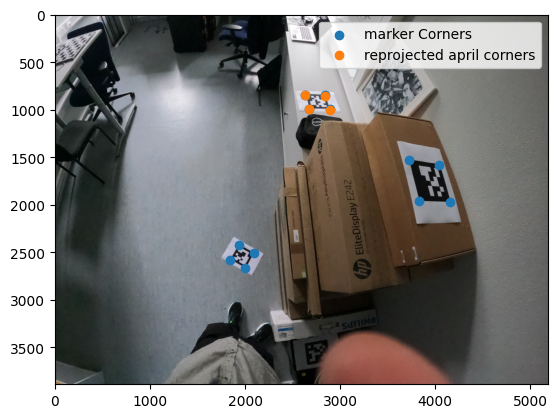

In [109]:
REPR_MARKER=1
rvec = rvecs[REPR_MARKER,0,:]
tvec = tvecs[REPR_MARKER,0,:]
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
camera_extrinsics = np.eye(4)
camera_extrinsics[:3, :3] = rotation_matrix
tvec = tvec.flatten()
#tvec = - rotation_matrix.T @ (tvec)
camera_extrinsics[:3, 3] = tvec
camera_mat = np.eye(4)
camera_mat[:3,:3] = mtx
P = camera_mat @ camera_extrinsics
P = P[:3,:] # we only had 4 rows for multiplication before
world_corners = objpts.reshape((-1,3))
image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
# recover homogeneous coordinates
image_pts = image_pts / image_pts[-1,:]
image_pts = image_pts[:2,:]
image_pts.T
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

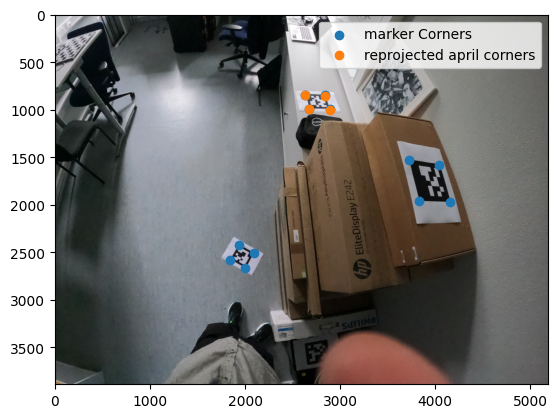